### Use pixel graphs to find an object's geodesic center
[link to example](https://scikit-image.org/docs/stable/auto_examples/applications/plot_pixel_graphs.html#sphx-glr-auto-examples-applications-plot-pixel-graphs-py)

In various image analysis situations, it is useful to think of an image, or of a region of an image, as a network or graph, in which each pixel is connected to its neighbors (with or without diagonals). One such situation is finding the geodesic center of an object, which is the point closest to all other points *if you are only allowed to travel on the pixels of the object*, rather than in a straight line. The point is the one with maximal *closeness centrality* in the network.

In this example, we create such a pixel graph of a skeleton and find the central pixel of that skeleton. This demonstrates its utility in contrast with the centroid (also known as the center of the mass) which may actually fall outside of object.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import skimage

We start by loading the data: an image of a human retina.

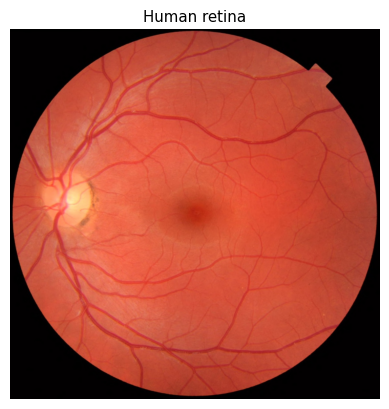

In [ ]:
retina_source = skimage.data.retina()
_, ax = plt.subplots()
ax.imshow(retina_source)
ax.set_axis_off()
_ = ax.set_title("Human retina")

We convert the image to grayscale, then use the `Sato vesselness filter` to better distinguish the main vessels in the image.

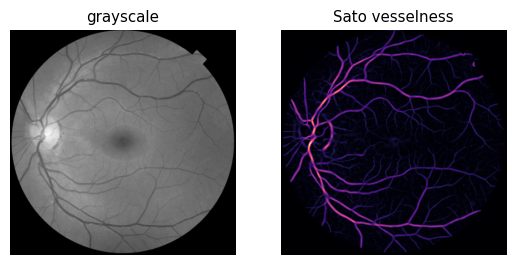

In [ ]:
retina = skimage.color.rgb2gray(retina_source)
t0, t1 = skimage.filters.threshold_multiotsu(retina, classes=3)
mask = retina > t0
vessels = skimage.filters.sato(retina, sigmas=range(1, 10)) * mask

_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(retina, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('grayscale')
axes[1].imshow(vessels, cmap='magma')
axes[1].set_axis_off()
_ = axes[1].set_title('Sato vesselness')

Based on the observed vesselness values, we use `hysteresis thresholding` to define the main vessels.

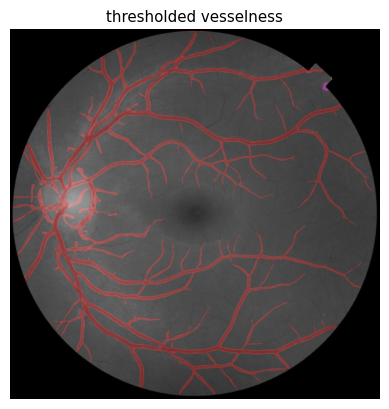

In [ ]:
thresholded = skimage.filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)
labeled = ndimage.label(thresholded)[0]

_, ax = plt.subplots()
ax.imshow(skimage.color.label2rgb(labeled, retina))
ax.set_axis_off()
_ = ax.set_title('thresholded vesselness')

Finally, we can `skeletonize` this label image and use that as the basis to find the `central pixel` in that skeleton. Compare that to the position of the centroid!

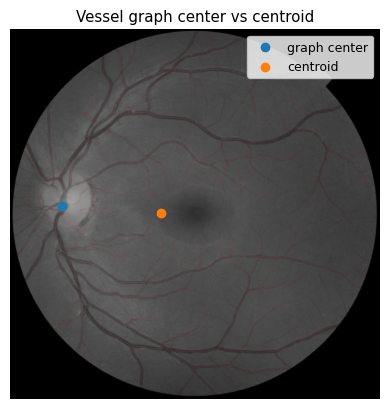

In [ ]:
largest_nonzero_label = np.argmax(np.bincount(labeled[labeled > 0]))
binary = labeled == largest_nonzero_label
skeleton = skimage.morphology.skeletonize(binary)
g, nodes = skimage.graph.pixel_graph(skeleton, connectivity=2)
px, distances = skimage.graph.central_pixel(
    g, nodes=nodes, shape=skeleton.shape, partition_size=100
)

centroid = skimage.measure.centroid(labeled > 0)
_, ax = plt.subplots()
ax.imshow(skimage.color.label2rgb(skeleton, retina))
ax.scatter(px[1], px[0], label='graph center')
ax.scatter(centroid[1], centroid[0], label='centroid')
ax.legend()
ax.set_axis_off()
ax.set_title('Vessel graph center vs centroid')
plt.show()